# Lag-Llama Fine Tuning

## Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 136 (delta 46), reused 52 (delta 26), pack-reused 55
Receiving objects: 100% (136/136), 195.29 KiB | 2.44 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 991.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpyscy3nwj
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 123MB/s]
/content/lag-llama/lag-llama.ckpt


In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-5-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    # prediction_length = horizon
    # context length = context of the data
    # num_samples = samples taken from the predicted distributions
    # batch_size = forecasting on the batches
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss

In [7]:
dataset = get_dataset("solar-energy")

In [8]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length*3
num_samples = 20
device = "cuda"

In [10]:
print(prediction_length,context_length)

24 72


In [9]:
forecasts, tss = get_lag_llama_predictions(
    dataset.test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/959 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/959 [00:00<?, ?it/s]

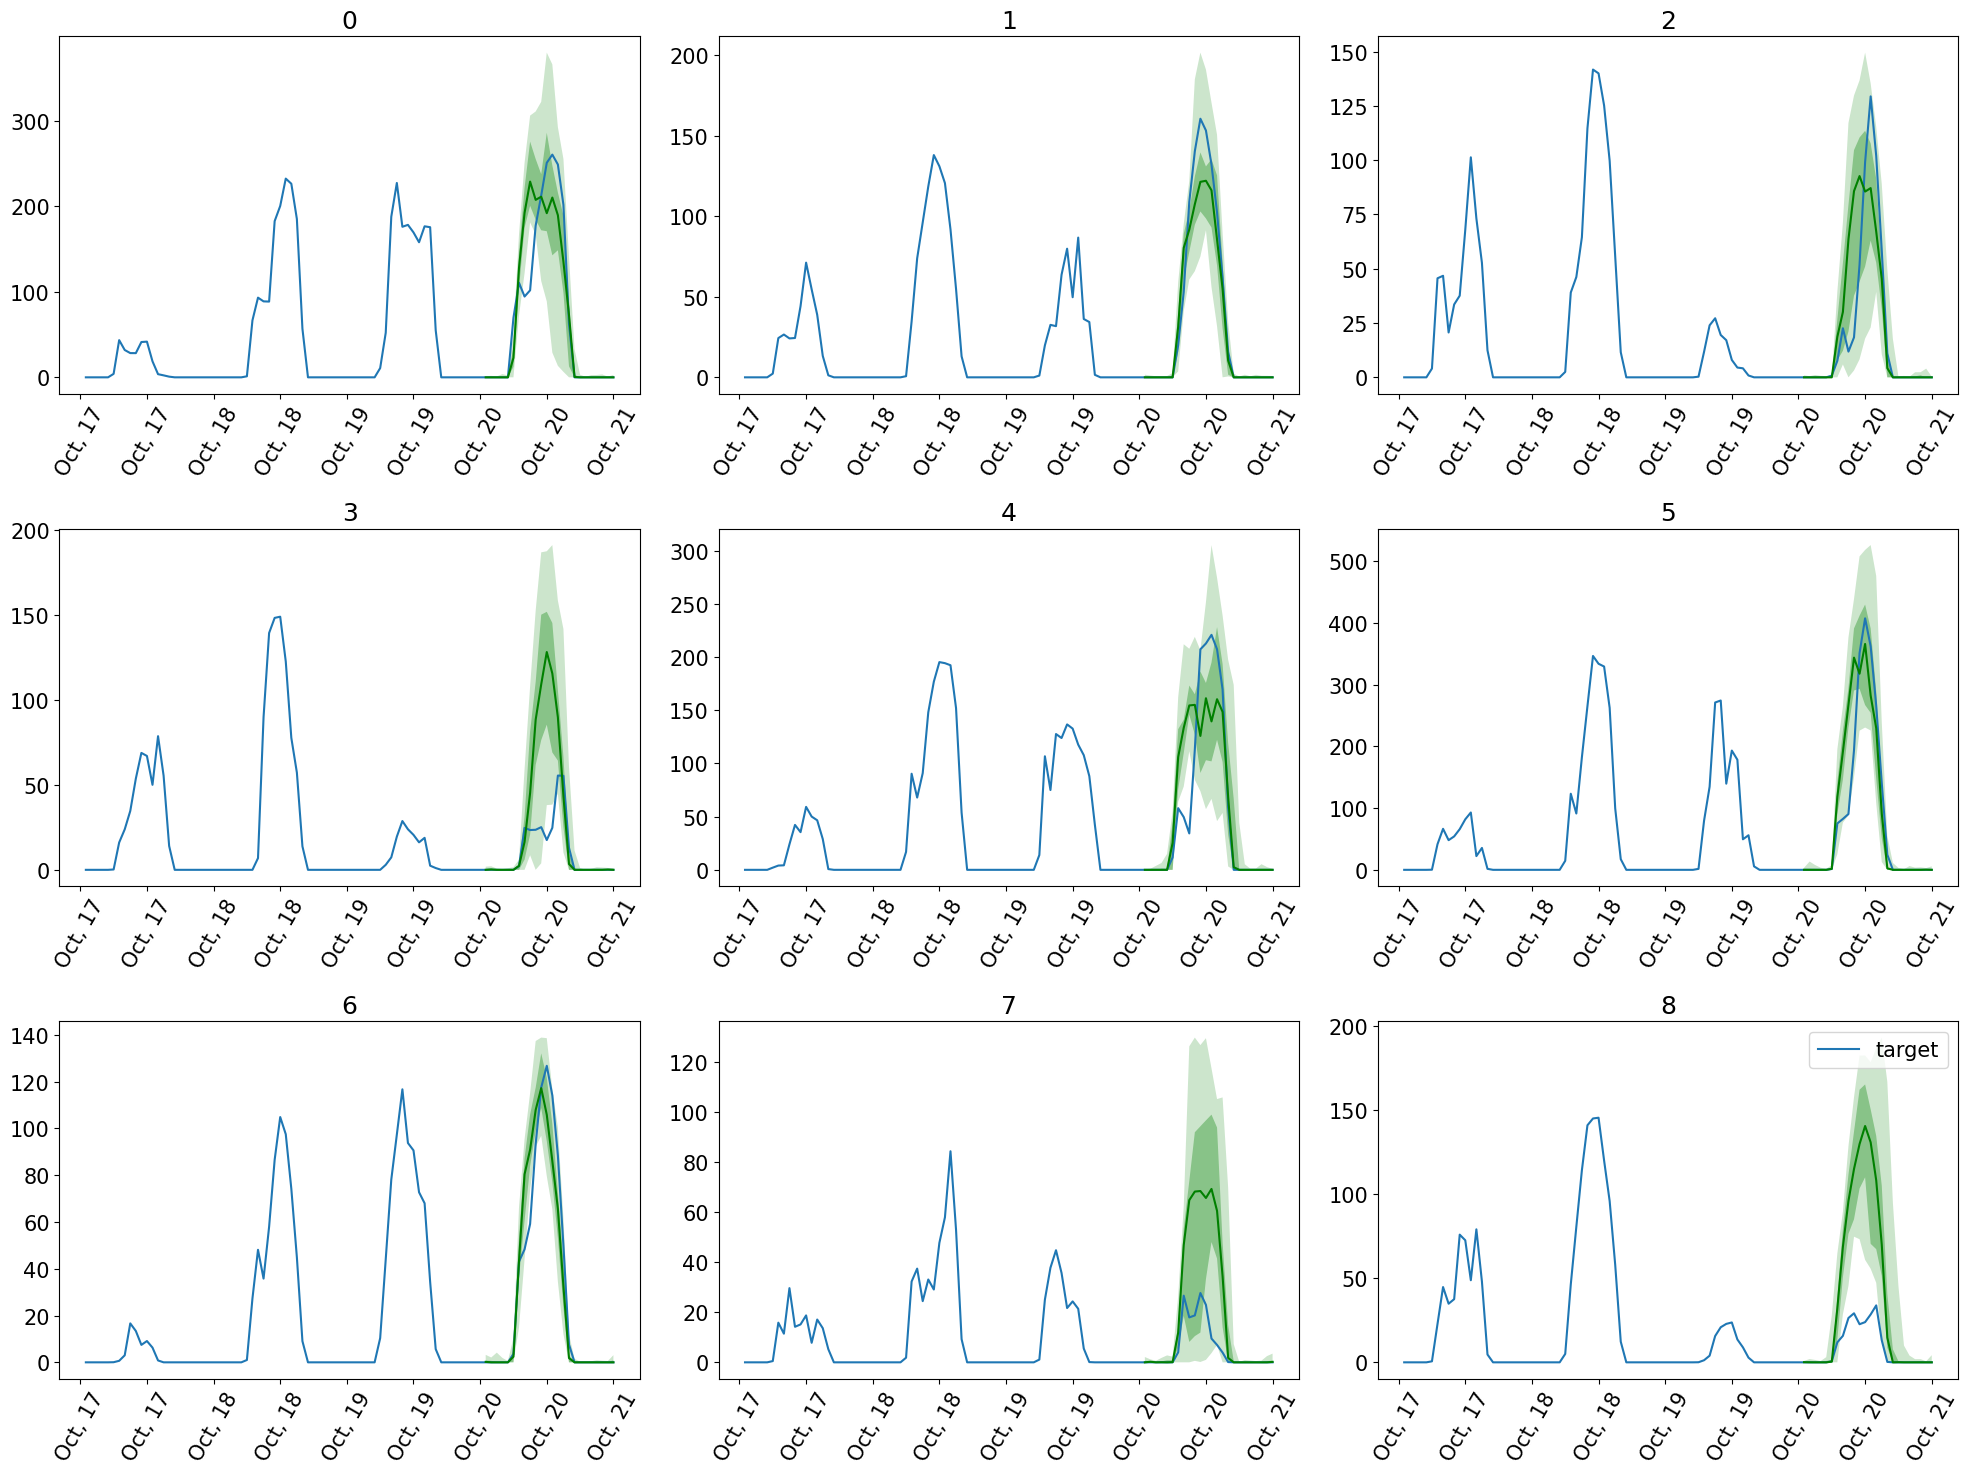

In [11]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %h' )
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [12]:
evaluator = Evaluator()

agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
agg_metrics

Running evaluation: 959it [00:00, 21974.70it/s]


{'MSE': 1184.6739141041926,
 'abs_error': 362975.82818984985,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 1.201823604072238,
 'MAPE': 2.7647793924132604,
 'sMAPE': 0.8171749880599755,
 'MSIS': 13.676882877724177,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 273565.58190824615,
 'Coverage[0.1]': 0.6954292665971499,
 'QuantileLoss[0.2]': 340356.14719934866,
 'Coverage[0.2]': 0.7233229058046576,
 'QuantileLoss[0.3]': 369902.9757874342,
 'Coverage[0.3]': 0.7486096628432396,
 'QuantileLoss[0.4]': 376372.17847408634,
 'Coverage[0.4]': 0.7774591588460202,
 'QuantileLoss[0.5]': 362975.82782839774,
 'Coverage[0.5]': 0.8085679527285367,
 'QuantileLoss[0.6]': 328820.46235990466,
 'Coverage[0.6]': 0.8255995828988529,
 'QuantileLoss[0.7]': 286413.7617868241,
 'Coverage[0.7]': 0.8632255822036843,
 'QuantileLoss[0.8]': 228110.93638491182,
 'Coverage[0.8]': 0.9010688216892596,
 'QuantileLoss[0.9]': 147731.7094

In [13]:
agg_metrics['RMSE'], agg_metrics['MAPE']

(34.41909229053248, 2.7647793924132604)

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [14]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [15]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1000)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentat

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 3.26135 (best 3.26135), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 3.26135 (best 3.26135), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 2.70870 (best 2.70870), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 2.70870 (best 2.70870), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 2.22334 (best 2.22334), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytor

In [16]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
        num_samples=num_samples
    )

In [17]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/3 [00:00<?, ?it/s]

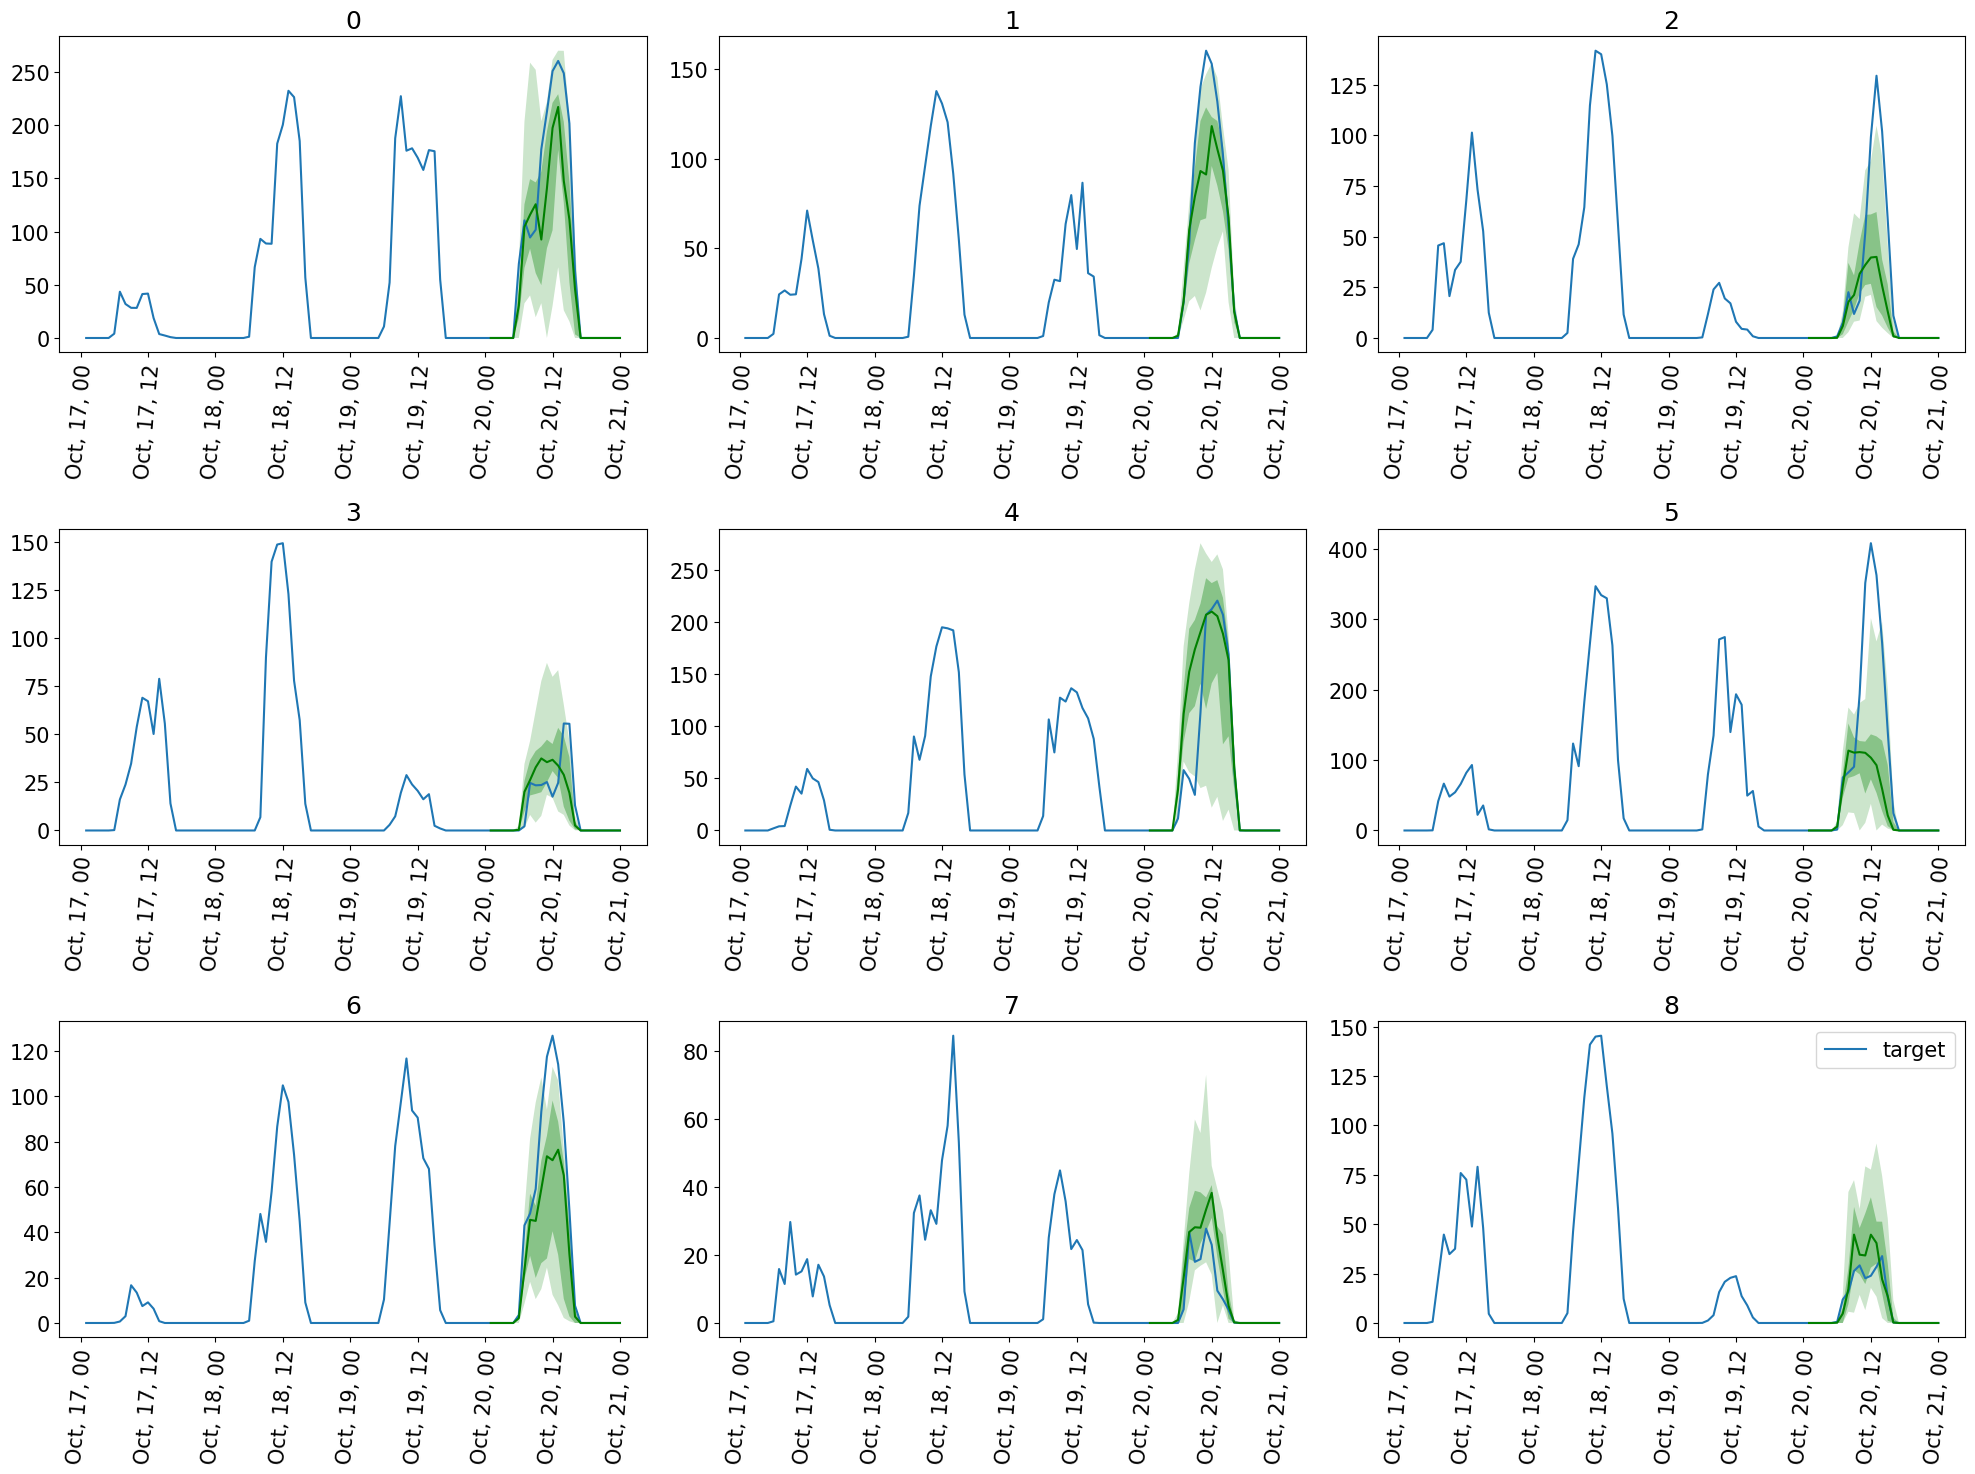

In [22]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d, %H')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=85)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [23]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 959it [00:00, 41173.24it/s]


In [24]:
agg_metrics

{'MSE': 790.5206490690856,
 'abs_error': 290386.24189186096,
 'abs_target_sum': 708873.5020904541,
 'abs_target_mean': 30.799161543728452,
 'seasonal_error': 13.175128459742648,
 'MASE': 0.9567153314636431,
 'MAPE': 2.3356844647959343,
 'sMAPE': 0.5649785291530075,
 'MSIS': 7.059165350628971,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 165055.26824994464,
 'Coverage[0.1]': 0.6435957594716718,
 'QuantileLoss[0.2]': 233914.68502927414,
 'Coverage[0.2]': 0.6820472714633298,
 'QuantileLoss[0.3]': 273621.95861060824,
 'Coverage[0.3]': 0.7164581160931525,
 'QuantileLoss[0.4]': 291549.3866178677,
 'Coverage[0.4]': 0.7499565519638512,
 'QuantileLoss[0.5]': 290386.24188153574,
 'Coverage[0.5]': 0.7791970802919708,
 'QuantileLoss[0.6]': 273005.4801628344,
 'Coverage[0.6]': 0.7957507820646506,
 'QuantileLoss[0.7]': 237371.83276877244,
 'Coverage[0.7]': 0.8334202294056309,
 'QuantileLoss[0.8]': 185535.55849282152,
 'Coverage[0.8]': 0.8724365658672227,
 'QuantileLoss[0.9]': 115077.64820

In [25]:
agg_metrics['RMSE'], agg_metrics['MAPE']

(28.11619905088676, 2.3356844647959343)

In [30]:
len(forecasts)

959

In [34]:
type(forecasts[0])

gluonts.model.forecast.SampleForecast

In [40]:
forecasts[0].quantile(0.9)

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 6.5222519e+01, 1.6851042e+02, 2.2458823e+02,
       2.4655667e+02, 2.0162178e+02, 2.0681088e+02, 2.4564952e+02,
       2.4550259e+02, 2.2540239e+02, 1.6388768e+02, 7.2697052e+01,
       8.8523515e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       5.8535993e-02, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

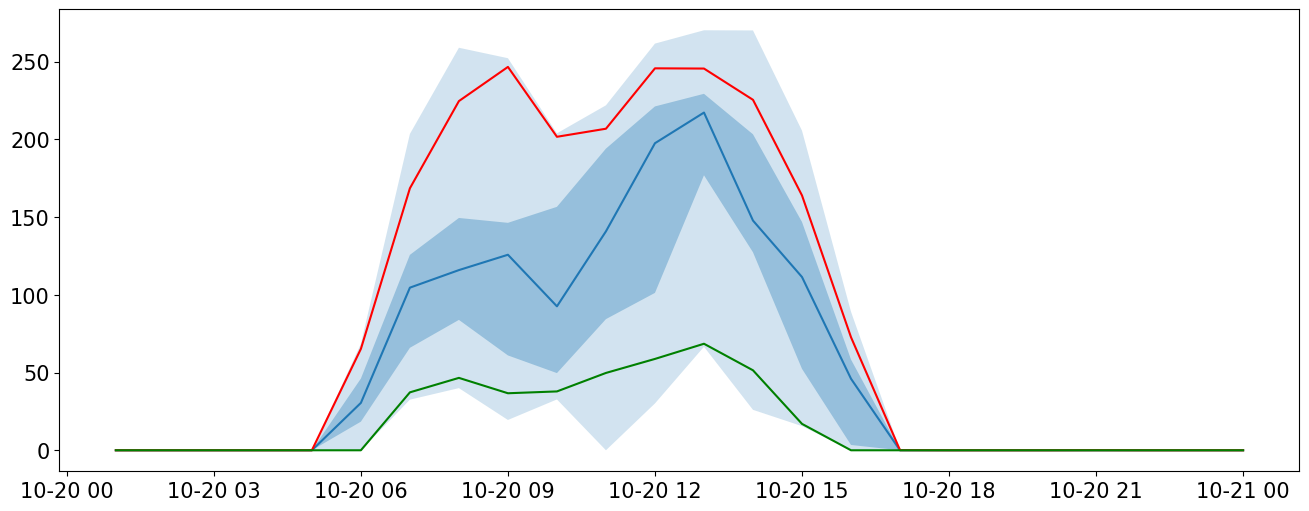

In [80]:
fig, ax = plt.subplots(1,figsize=(16,6))
forecasts[0].plot()
ax.plot(forecasts[0].mean_ts.index.to_timestamp(),forecasts[0].quantile(0.9),color='red')
ax.plot(forecasts[0].mean_ts.index.to_timestamp(),forecasts[0].quantile(0.1),color='red')


In [67]:
forecasts[0].mean_ts.index.to_timestamp()

DatetimeIndex(['2006-10-20 01:00:00', '2006-10-20 02:00:00',
               '2006-10-20 03:00:00', '2006-10-20 04:00:00',
               '2006-10-20 05:00:00', '2006-10-20 06:00:00',
               '2006-10-20 07:00:00', '2006-10-20 08:00:00',
               '2006-10-20 09:00:00', '2006-10-20 10:00:00',
               '2006-10-20 11:00:00', '2006-10-20 12:00:00',
               '2006-10-20 13:00:00', '2006-10-20 14:00:00',
               '2006-10-20 15:00:00', '2006-10-20 16:00:00',
               '2006-10-20 17:00:00', '2006-10-20 18:00:00',
               '2006-10-20 19:00:00', '2006-10-20 20:00:00',
               '2006-10-20 21:00:00', '2006-10-20 22:00:00',
               '2006-10-20 23:00:00', '2006-10-21 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [78]:
forecasts[200].mean_ts.index.to_timestamp()

DatetimeIndex(['2006-10-21 01:00:00', '2006-10-21 02:00:00',
               '2006-10-21 03:00:00', '2006-10-21 04:00:00',
               '2006-10-21 05:00:00', '2006-10-21 06:00:00',
               '2006-10-21 07:00:00', '2006-10-21 08:00:00',
               '2006-10-21 09:00:00', '2006-10-21 10:00:00',
               '2006-10-21 11:00:00', '2006-10-21 12:00:00',
               '2006-10-21 13:00:00', '2006-10-21 14:00:00',
               '2006-10-21 15:00:00', '2006-10-21 16:00:00',
               '2006-10-21 17:00:00', '2006-10-21 18:00:00',
               '2006-10-21 19:00:00', '2006-10-21 20:00:00',
               '2006-10-21 21:00:00', '2006-10-21 22:00:00',
               '2006-10-21 23:00:00', '2006-10-22 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [79]:
len(forecasts)

959

In [91]:
ts.head()

,0
2006-01-01 00:00,0.0
2006-01-01 01:00,0.0
2006-01-01 02:00,0.0
2006-01-01 03:00,0.0
2006-01-01 04:00,0.0


In [85]:
dataset.train.

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7843ca46c1c0>, iterable=JsonLinesFile(path=PosixPath('/root/.gluonts/datasets/solar-energy/train/data.json.gz'), start=0, n=None, line_starts=[0, -16798, 30108, 11499, -7150, -23773, 25379, 6904, -11776, -30687, 16137, -2476, -21953, 24809, 6335, -12659, -31288, 15343, -3277, -22283, 24746, 6107, -12793, -31653, 16481, -2254, -20662, 26071, 7712, -9629, -28088, 19728, 2260, -16740, 30233, 11372, -7268, -26176, 20685, 2043, -16731, 31598, 13043, -5676, -24197, 23555, 5524, -12623, -31540, 15179, -3813, -22373, 24562, 5778, -12669, -31019, 15343, -3229, -21731, 25575, 7395, -11273, -30153, 16371, -2127, -20814, 25694, 7040, -11504, -28549, 19645, 1841, -16793, 30542, 13885, -4845, -23535, 23659, 5327, -13204, -32230, 15463, -3258, -21654, 24963, 6562, -12142, -31256, 15498, -3048, -21926, 25618, 6944, -12223, -30603, 15688, -3017, -21222, 25620, 6645, -11922, -31077, 15829, -3061, -21893, 26448, 9034, -10047, -28533, 18848, -100

In [88]:
from gluonts.dataset.util import to_pandas
train_data = to_pandas(next(iter(dataset.train)))

In [90]:

train_data.shape

(7009,)

In [92]:
next(iter(dataset.train))

{'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'start': Period('2006-01-01 00:00', 'H'),
 'feat_static_cat': array([0], dtype=int32),
 'item_id': 0}

In [93]:
next(iter(dataset.test))

{'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'start': Period('2006-01-01 00:00', 'H'),
 'feat_static_cat': array([0], dtype=int32),
 'item_id': 0}

In [97]:
dataset.index

<function TrainDatasets.index(value, start=0, stop=9223372036854775807, /)>

In [102]:
dataset.metadata

MetaData(freq='1H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)